In [2]:
# Getting data from transactions.txt

with open('transaction.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='|')
    line_count = 0
    for row in csv_reader:
        transactions.append(json.loads(row[0])) 
        line_count += 1
    print("Processed {line_count} lines.".format(line_count=line_count))
    
#creating a pandas data frame
import pandas as pd
df = pd.DataFrame(transactions) 

Processed 786363 lines.


In [3]:
# Feature engineering and data preprocessing

# Complete the call to convert the date column
df['transactionDateTime'] =  pd.to_datetime(df['transactionDateTime'])

df['currentExpDate'] =  pd.to_datetime(df['currentExpDate'])

df['accountOpenDate'] =  pd.to_datetime(df['accountOpenDate'])

df['dateOfLastAddressChange'] =  pd.to_datetime(df['dateOfLastAddressChange'])


# Encode categorical variables

from sklearn.preprocessing import LabelEncoder
ToEncodeVars = ['accountNumber', 'customerId','merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode','transactionType', 'echoBuffer', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch','cardCVV', 'enteredCVV', 'cardLast4Digits', 'isFraud']
enc=LabelEncoder()


# Transform categorical qualitative data into labels
for i in ToEncodeVars:
    df[[i]] = enc.fit_transform(df[[i]])

enc_data=df.iloc[:,:]

# Dropping less important variables 
data = enc_data.drop(columns=['currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'accountNumber', 'customerId', 'acqCountry', 'merchantCountryCode', 
                              'posEntryMode', 'posConditionCode', 'echoBuffer', 'currentBalance', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises',
                              'recurringAuthInd', 'expirationDateKeyInMatch', 'availableMoney', 'enteredCVV'])


# Feature engineering: Converting datetime to a new field seconds

startTime = data.transactionDateTime.loc[0]
endTime = data.transactionDateTime.loc[1]
position = data.columns.get_loc('transactionDateTime')
data['elapsed'] =  data.iloc[1:, position] - data.iat[0, position]
seconds=data.elapsed.dt.total_seconds() 
data['seconds'] = seconds
data = data.drop(columns=['transactionDateTime', 'elapsed'])
dataset = data.drop(columns=['isFraud']).fillna(0)
target = data['isFraud'].fillna(0)

In [4]:
# Preparing the dataset and target variables

dataset = data.drop(columns=['isFraud']).fillna(0)
target = data['isFraud'].fillna(0)


# Splitting the Dataset and target into Break set and Testing set and stratifying for the minority class
#X_train, X_test, Y_train, Y_test = train_test_split(dataset, target, \
                                                   # test_size=0.2, stratify=df['isFraud'],
                                                  # random_state=42)

X_break, X_test, y_break, y_test = train_test_split(dataset, target, \
                                                    test_size=0.2, stratify=df['isFraud'],
                                                    random_state=42)

# Splitting the Break set into training andvalidation set
X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=42)

# Standardize for the long tail of Dataset
std_scale = StandardScaler().fit(X_train)

# Scale data
X_train_std = std_scale.transform(X_train)
X_val_std = std_scale.transform(X_val)
X_test_std = std_scale.transform(X_test)

# Use Random undersampler from the majority class to correct for Imbalanced class model
X_train_under, y_train_under = RandomUnderSampler(random_state=42).fit_sample(X_train_std,y_train)
X_val_under, y_val_under = RandomUnderSampler(random_state=42).fit_sample(X_val_std,y_val)

In [5]:
# Cross-Validation with logit

penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1875s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    1.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.15443469e+01, 4.64158883e+02, 1.00000000e+04,
       2.15443469e+05, 4.64158883e+06, 1.00000000e+08, 2.15443469e+09,
       4.64158883e+10, 1.00000000e+12]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
        

In [6]:
# save the model to disk
filename = 'logistic_grid.sav'
pickle.dump(logistic_grid, open(filename, 'wb'))
 
# load the model from disk
loaded_logistic_grid_model= pickle.load(open(filename, 'rb'))
result = loaded_logistic_grid_model.score(X_test_std, y_test)
print(result)

0.6816651102033526


In [7]:
# Cross Validation with 5 folds SVM

C = [1]
gammas = [0.001, 0.1] 
param_grid = dict(C=C, gamma=gammas)
svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svm_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.6min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.6min remaining:   41.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1], 'gamma': [0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

In [8]:
# save the model to disk
filename = 'svm_grid.sav'
pickle.dump(svm_grid, open(filename, 'wb'))
 
# load the model from disk
loaded_svm_grid_model= pickle.load(open(filename, 'rb'))
result = loaded_svm_grid_model.score(X_test_std, y_test)
print(result)

0.7186171814972733


In [9]:
# Cross Validation with Random Forest

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train_under,y_train_under)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:  9.6min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [10]:
# save the model to disk
filename = 'rf_grid.sav'
pickle.dump(rf_grid, open(filename, 'wb'))
 
# load the model from disk
loaded_rf_grid_model= pickle.load(open(filename, 'rb'))
result = loaded_rf_grid_model.score(X_test_std, y_test)
print(result)

0.7913802928978362


In [11]:
# Naive Bayes Classifier Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train_under, y_train_under)


# save the model to disk
filename = 'gnb_best.sav'
pickle.dump(gnb_best, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_gnb_model= pickle.load(open(filename, 'rb'))
result = loaded_gnb_model.score(X_test_std, y_test)
print(result)



0.5219777075531082


In [12]:
# Baseline Dummy Classifier
dummy = DummyClassifier()
dummy.fit(X_train_under, y_train_under)

# save the model to disk
filename = 'dummy.sav'
pickle.dump(dummy, open(filename, 'wb'))
 
# load the model from disk
loaded_dummy_model= pickle.load(open(filename, 'rb'))
result = loaded_dummy_model.score(X_test_std, y_test)
print(result)



0.5006262994919662


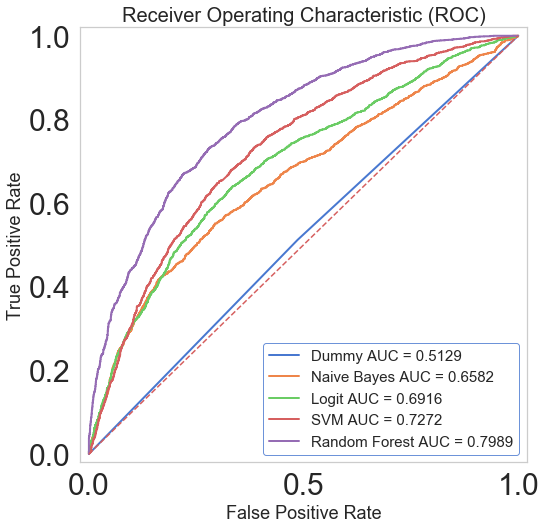

In [13]:
# Evaluating performance: Calculating ROC-AUC Scores
def roc_scores(X_value, Y_value):
    #in sample
    model_list = [dummy,
                  gnb_best,
                  logistic_grid.best_estimator_, 
                  svm_grid.best_estimator_, 
                  rf_grid.best_estimator_
                  ]

    model_name = ['Dummy', 'Naive Bayes','Logit','SVM','Random Forest',]

    # Plot ROC curve for all my models
    fig, ax = plt.subplots(figsize=(8,8))
    for i, model in enumerate(model_list):
        y_pred = list(model.predict_proba(X_value)[:,1])
        fpr, tpr, threshold = metrics.roc_curve(Y_value, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=2.0)
    ax.grid(False)
    ax.tick_params(length=6, width=2,labelsize = 30,
                   grid_color='r', grid_alpha=0.5)
    leg = plt.legend(loc = 'lower right',prop={'size': 15})
    leg.get_frame().set_edgecolor('b')
    plt.title('Receiver Operating Characteristic (ROC)', FontSize=20)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate',FontSize=18)
    plt.xlabel('False Positive Rate',FontSize=18)
    plt.show()
    
roc_scores(X_val_under,y_val_under)

In [14]:
def find_best_threshold(model, int_num_steps):
    highest_f1 = 0
    best_threshold = 0
    for threshold in np.linspace (0, 1, int_num_steps):
        y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold) 
        f1 = f1_score(y_val_under,y_predict)
        acc = accuracy_score(y_val_under,y_predict)
        rec = recall_score(y_val_under,y_predict)
        pre = precision_score(y_val_under,y_predict)
        if f1 > highest_f1:
            best_threshold, highest_f1, best_acc, best_rec, best_pre  = \
                threshold, f1, acc, rec, pre
    return best_threshold, highest_f1, best_acc, best_rec, best_pre

In [15]:
#Performance chart
models = [dummy,logistic_grid, gnb_best, svm_grid, rf_grid]
model_names = ["Dummy",  "Logistic Regression", "Naive-Bayes", "SVM", "Random Forest"]
chart = list()
for item,name in zip(models,model_names):
    best_thresh, high_f1, high_acc, high_rec, high_pre = find_best_threshold(item,20)
    chart.append([name, best_thresh, high_f1, high_acc, high_rec, high_pre])
chart = pd.DataFrame(chart, columns=['Model', 'Best Threshhold','F1 Score','Accuracy','Recall','Precision'])    
chart

,Model,Best Threshhold,F1 Score,Accuracy,Recall,Precision
0,Dummy,0.000000,0.666667,0.500000,1.000000,0.500000
1,Logistic Regression,0.315789,0.678091,0.561393,0.923913,0.535589
2,Naive-Bayes,0.000000,0.666667,0.500000,1.000000,0.500000
3,SVM,0.315789,0.702807,0.629227,0.876812,0.586430
4,Random Forest,0.421053,0.738899,0.704106,0.837359,0.661157


#Cost-sensitive learning: instead of each instance being either correctly or incorrectly classified, each class (or instance) is given a misclassification cost. Thus, instead of trying to optimize the accuracy, we minimize the total misclassification cost.

In [16]:
# Data preparation
data_cost_saving = df.drop(columns = ['accountNumber', 'customerId', 
       'transactionDateTime', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'transactionType', 'echoBuffer', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch'])
target = df['isFraud']
X_break, X_test, y_break, y_test = train_test_split(data_cost_saving, target, \
                                                    test_size=0.2, stratify=df['isFraud'],
                                                    random_state=42)

#random_state generates a set kind of deck for each random state. 42 will always be the same kind of split
X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=42)
# Initialize fit StandardScaler
std_scale = StandardScaler().fit(X_train)

# Scale data
X_train_std = std_scale.transform(X_train)
X_val_std = std_scale.transform(X_val)
X_test_std = std_scale.transform(X_test)

dataset = data_cost_saving.drop(columns=['isFraud','creditLimit']).fillna(0)
target = data_cost_saving['isFraud'].fillna(0)

In [17]:
# Defining data and classification costs
import ANN, eval_results

X = dataset
y = target
sc = StandardScaler()
X = sc.fit_transform(X)

amount = dataset['transactionAmount']
cost_FP = 1
cost_FN = amount
cost_TP = 1
cost_TN = 0
cost_mat = np.array([cost_FP * np.ones(dataset.shape[0]), cost_FN, 
                     cost_TP * np.ones(dataset.shape[0]), 
                     cost_TN * np.ones(dataset.shape[0])]).T

In [18]:
# Data into train / test splits (5-fold CV):
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=123, shuffle=True)
kf.get_n_splits(X)
X_train_l, X_test_l = [], []
y_train_l, y_test_l = [], []
cost_mat_train_l, cost_mat_test_l = [], []
for train_index, test_index in kf.split(X):
    X_train_l.append(X[train_index, :])
    X_test_l.append(X[test_index, :])
    y_train_l.append(y.iloc[train_index])
    y_test_l.append(y.iloc[test_index])
    cost_mat_train_l.append(cost_mat[train_index, :])
    cost_mat_test_l.append(cost_mat[test_index, :])

In [19]:
# Random model 2 #
y_pred_train_rand, y_pred_test_rand = [], []
print('Random Model ...')
for y_train, y_test in zip(y_train_l, y_test_l):
    y_pos_train = y_train.sum() / y_train.shape[0]
    y_pred_train_rand.append(np.random.binomial(1, y_pos_train, y_train.shape[0]))
    y_pred_test_rand.append(np.random.binomial(1, y_pos_train, y_test.shape[0]))

Random Model ...


In [20]:
# Logistic Regression #
y_pred_train_lr_probas, y_pred_test_lr_probas = [], []
y_pred_train_lr, y_pred_test_lr = [], []
for i, (X_train, X_test, y_train) in enumerate(zip(X_train_l, X_test_l, y_train_l)):
    print('Logistic regression ' + str(i + 1) + '/' + str(n_splits) + ' ...')
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred_train_lr_probas.append(np.round(lr.predict_proba(X_train)[:, 1], 3))
    y_pred_test_lr_probas.append(np.round(lr.predict_proba(X_test)[:, 1], 3))
    y_pred_train_lr.append(lr.predict(X_train))
    y_pred_test_lr.append(lr.predict(X_test))

Logistic regression 1/5 ...
Logistic regression 2/5 ...
Logistic regression 3/5 ...
Logistic regression 4/5 ...
Logistic regression 5/5 ...


In [21]:
# ANN #
y_pred_train_ann_probas, y_pred_test_ann_probas = [], []
y_pred_train_ann, y_pred_test_ann = [], []
for i, (X_train, X_test, y_train) in enumerate(zip(X_train_l, X_test_l, y_train_l)):
    print('ANN ' + str(i + 1) + '/' + str(n_splits) + ' ...')
    clf = ANN.clf(indput_dim=X_train.shape[1], dropout=0.2)
    clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    clf.fit(X_train, y_train, batch_size=50, epochs=2, verbose=1)
    y_pred_train_ann_proba = np.round(clf.predict(X_train, verbose=1), 3).reshape(-1)
    y_pred_test_ann_proba = np.round(clf.predict(X_test, verbose=1), 3).reshape(-1)
    y_pred_train_ann_probas.append(y_pred_train_ann_proba)
    y_pred_test_ann_probas.append(y_pred_test_ann_proba)
    y_pred_train_ann.append((y_pred_train_ann_proba > 0.5).astype(int).reshape(-1))
    y_pred_test_ann.append((y_pred_test_ann_proba > 0.5).astype(int).reshape(-1))

ANN 1/5 ...
Epoch 1/2
629090/629090 [==============================] - 16s 25us/step - loss: 0.0836 - accuracy: 0.9842
Epoch 2/2
157273/157273 [==============================] - 1s 8us/step
ANN 2/5 ...
Epoch 1/2
629090/629090 [==============================] - 13s 21us/step - loss: 0.0841 - accuracy: 0.9842
Epoch 2/2
157273/157273 [==============================] - 1s 8us/step
ANN 3/5 ...
Epoch 1/2
629090/629090 [==============================] - 14s 22us/step - loss: 0.0836 - accuracy: 0.9841
Epoch 2/2
157273/157273 [==============================] - 1s 8us/step
ANN 4/5 ...
Epoch 1/2
629091/629091 [==============================] - 17s 27us/step - loss: 0.0833 - accuracy: 0.9843
Epoch 2/2
157272/157272 [==============================] - 6s 41us/step
ANN 5/5 ...
Epoch 1/2
629091/629091 [==============================] - 29s 46us/step - loss: 0.0840 - accuracy: 0.9841
Epoch 2/2
157272/157272 [==============================] - 2s 12us/step


In [25]:
# Cost Sensitive #
y_pred_train_ann_cs_probas, y_pred_test_ann_cs_probas = [], []
y_pred_train_ann_cs, y_pred_test_ann_cs = [], []
for i, (X_train, X_test, y_train, cost_mat_train) in enumerate(zip(X_train_l, 
                                   X_test_l, y_train_l, cost_mat_train_l)): 
    print('ANN Cost Sensitive ' + str(i + 1) + '/' + str(n_splits) + ' ...')
    cost_FN_train = cost_mat_train[:, 1]
    y_input = ANN.create_y_input(y_train, cost_FN_train).apply(float)
    clf = ANN.clf(indput_dim=X_train.shape[1], dropout=0.2)
    clf.compile(optimizer='adam', loss=ANN.custom_loss(cost_FP, cost_TP, cost_TN),
                metrics=['accuracy'])
    clf.fit(X_train, y_input, batch_size=50, epochs=2, verbose=1)
    y_pred_train_ann_cs_proba = clf.predict(X_train, verbose=1)
    y_pred_test_ann_cs_proba = clf.predict(X_test, verbose=1)
    y_pred_train_ann_cs_probas.append(y_pred_train_ann_cs_proba)
    y_pred_test_ann_cs_probas.append(y_pred_test_ann_cs_proba)
    y_pred_train_ann_cs.append((y_pred_train_ann_cs_proba > 0.5).\
                               astype(int).reshape(-1))
    y_pred_test_ann_cs.append((y_pred_test_ann_cs_proba > 0.5).\
                              astype(int).reshape(-1))

ANN Cost Sensitive 1/5 ...
Epoch 1/2
629090/629090 [==============================] - 17s 27us/step - loss: 1.7376 - accuracy: 0.0332
Epoch 2/2
157273/157273 [==============================] - 1s 7us/step
ANN Cost Sensitive 2/5 ...
Epoch 1/2
629090/629090 [==============================] - 17s 27us/step - loss: 1.7234 - accuracy: 0.0334
Epoch 2/2
157273/157273 [==============================] - 2s 10us/step
ANN Cost Sensitive 3/5 ...
Epoch 1/2
629090/629090 [==============================] - 17s 27us/step - loss: 1.7415 - accuracy: 0.0335
Epoch 2/2
157273/157273 [==============================] - 8s 53us/step
ANN Cost Sensitive 4/5 ...
Epoch 1/2
629091/629091 [==============================] - 204s 325us/step - loss: 1.7287 - accuracy: 0.0334
Epoch 2/2
157272/157272 [==============================] - 1s 9us/step
ANN Cost Sensitive 5/5 ...
Epoch 1/2
629091/629091 [==============================] - 15s 24us/step - loss: 1.8029 - accuracy: 0.0332
Epoch 2/2
157272/157272 [=================

In [26]:
# cost-classification Logistic Regression classified according to expected minimum costs (mc)
y_pred_train_lr_mc, y_pred_test_lr_mc = [], []
for y_train_proba, y_test_proba, cm_train, cm_test in zip(y_pred_train_lr_probas,\
                            y_pred_test_lr_probas, cost_mat_train_l, cost_mat_test_l):
    cost_0 = (1 - y_train_proba) * cm_train[:, 3] + y_train_proba * cm_train[:, 1]
    cost_1 = (1 - y_train_proba) * cm_train[:, 0] + y_train_proba * cm_train[:, 2]
    y_pred_train_lr_mc.append((cost_1 < cost_0).astype(int))        
    cost_0 = (1 - y_test_proba) * cm_test[:, 3] + y_test_proba * cm_test[:, 1]
    cost_1 = (1 - y_test_proba) * cm_test[:, 0] + y_test_proba * cm_test[:, 2]
    y_pred_test_lr_mc.append((cost_1 < cost_0).astype(int))

In [27]:
# cost-classified ANN classified according to expected minimum costs (mc)
y_pred_train_ann_mc, y_pred_test_ann_mc = [], []
for y_train_proba, y_test_proba, cm_train, cm_test in zip(y_pred_train_ann_probas,\
                            y_pred_test_ann_probas, cost_mat_train_l, cost_mat_test_l):
    cost_0 = (1 - y_train_proba) * cm_train[:, 3] + y_train_proba * cm_train[:, 1]
    cost_1 = (1 - y_train_proba) * cm_train[:, 0] + y_train_proba * cm_train[:, 2]
    y_pred_train_ann_mc.append((cost_1 < cost_0).astype(int))  
    cost_0 = (1 - y_test_proba) * cm_test[:, 3] + y_test_proba * cm_test[:, 1]
    cost_1 = (1 - y_test_proba) * cm_test[:, 0] + y_test_proba * cm_test[:, 2]
    y_pred_test_ann_mc.append((cost_1 < cost_0).astype(int))

In [28]:
# ---------- Save results ---------- #
np.save('results/cost_mat_train_l', cost_mat_train_l)
np.save('results/cost_mat_test_l', cost_mat_test_l)
np.save('results/y_pred_train_lr.npy', y_pred_train_lr)
np.save('results/y_pred_test_lr.npy', y_pred_test_lr)
np.save('results/y_pred_train_lr_probas.npy', y_pred_train_lr_probas)
np.save('results/y_pred_test_lr_probas.npy', y_pred_test_lr_probas)
np.save('results/y_pred_train_ann.npy', y_pred_train_ann)
np.save('results/y_pred_test_ann.npy', y_pred_test_ann)
np.save('results/y_pred_train_ann_probas.npy', y_pred_train_ann_probas)
np.save('results/y_pred_test_ann_probas.npy', y_pred_test_ann_probas)
np.save('results/y_pred_train_ann_cs.npy', y_pred_train_ann_cs)
np.save('results/y_pred_test_ann_cs.npy', y_pred_test_ann_cs)
np.save('results/y_pred_train_ann_cs_probas.npy', y_pred_train_ann_cs_probas)
np.save('results/y_pred_test_ann_cs_probas.npy', y_pred_test_ann_cs_probas)
np.save('results/y_pred_train_lr_mc.npy', y_pred_train_lr_mc)
np.save('results/y_pred_test_lr_mc.npy', y_pred_test_lr_mc)
np.save('results/y_pred_train_ann_mc.npy', y_pred_train_ann_mc)
np.save('results/y_pred_test_ann_mc.npy', y_pred_test_ann_mc)

In [29]:
# Evaluate results #
eval_results.evaluate('Random', y_train_l, y_test_l, y_pred_train_rand, y_pred_test_rand,
                      cost_mat_train_l, cost_mat_test_l)
eval_results.evaluate('Logistic Regression', y_train_l, y_test_l, y_pred_train_lr, 
                      y_pred_test_lr, cost_mat_train_l, cost_mat_test_l)
eval_results.evaluate('ANN', y_train_l, y_test_l, y_pred_train_ann, y_pred_test_ann,
                      cost_mat_train_l, cost_mat_test_l)
eval_results.evaluate('ANN Cost Sensitive', y_train_l, y_test_l, y_pred_train_ann_cs, 
                      y_pred_test_ann_cs, cost_mat_train_l, cost_mat_test_l)
eval_results.evaluate('Logistic Regression (min costs)', y_train_l, y_test_l, 
                      y_pred_train_lr_mc, y_pred_test_lr_mc, cost_mat_train_l, 
                      cost_mat_test_l)
eval_results.evaluate('ANN (min costs)', y_train_l, y_test_l, y_pred_train_ann_mc,
                      y_pred_test_ann_mc, cost_mat_train_l, cost_mat_test_l)


--------------------
Random
Positives train     0.016, individual: [0.016, 0.016, 0.016, 0.015, 0.016]
Positives test:     0.016, individual: [0.016, 0.016, 0.016, 0.015, 0.016]
F1-score train:     0.015, individual: [0.013, 0.015, 0.014, 0.017, 0.014]
F1-score test:      0.016, individual: [0.016, 0.013, 0.019, 0.015, 0.015]
Cost savings train: 0.01, individual: [0.008, 0.009, 0.01, 0.013, 0.009]
Cost savings test:  0.01, individual: [0.011, 0.008, 0.016, 0.007, 0.008]
--------------------
Logistic Regression
Positives train     0.0, individual: [0.0, 0.0, 0.0, 0.0, 0.0]
Positives test:     0.0, individual: [0.0, 0.0, 0.0, 0.0, 0.0]
F1-score train:     0.0, individual: [0.0, 0.0, 0.0, 0.0, 0.0]
F1-score test:      0.0, individual: [0.0, 0.0, 0.0, 0.0, 0.0]
Cost savings train: 0.0, individual: [-0.0, -0.0, -0.0, -0.0, -0.0]
Cost savings test:  0.0, individual: [-0.0, -0.0, -0.0, -0.0, 0.0]
--------------------
ANN
Positives train     0.0, individual: [0.0, 0.0, 0.0, 0.0, 0.0]
Positives

In [30]:
y = target
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=123, shuffle=True)
kf.get_n_splits(y)
train_index_l, test_index_l = [], []
y_train_l, y_test_l = [], []
for train_index, test_index in kf.split(y):
    train_index_l.append(train_index)
    test_index_l.append(test_index)
    y_train_l.append(y.iloc[train_index])
    y_test_l.append(y.iloc[test_index])

In [31]:
def stack_y_probas(y_proba):
    y_proba = np.hstack((y_proba, 1 - y_proba))
    return np.array([y_proba[:int(y_proba.shape[0]/2)], y_proba[int(y_proba.shape[0]/2):]]).T

def create_roc_auc(y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

# Create mean roc_auc for list of CV results:
def create_mean_roc_auc(y_true_l, y_pred_l):
    fpr_l, tpr_l, roc_auc_l, tprs_l = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    for y_true, y_pred in zip(y_true_l, y_pred_l):
        fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
        tprs_l.append(interp(mean_fpr, fpr[1], tpr[1]))
        tprs_l[-1][0] = 0.0
        roc_auc_l.append(roc_auc)
    mean_tpr = np.mean(tprs_l, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc

In [32]:
# transform data to right format
y_test_2D = []
for y_test in y_test_l:
    y_test = LabelBinarizer().fit_transform(y_test)
    y_test = np.hstack((y_test, 1 - y_test))
    y_test_2D.append(y_test)
y_pred_test_lr_probas_2D, y_pred_test_ann_probas_2D, y_pred_test_ann_cs_probas_2D = [], [], []
for i in range(n_splits):
    y_pred_test_lr_probas_2D.append(stack_y_probas(y_pred_test_lr_probas[i]))
    y_pred_test_ann_probas_2D.append(stack_y_probas(y_pred_test_ann_probas[i]))
    y_pred_test_ann_cs_probas_2D.append(stack_y_probas(y_pred_test_ann_cs_probas[i].reshape(-1)))

# calculate mean curves:
mean_fpr_lr, mean_tpr_lr, mean_auc_lr = create_mean_roc_auc(y_test_2D, y_pred_test_lr_probas_2D)
mean_fpr_ann, mean_tpr_ann, mean_auc_ann = create_mean_roc_auc(y_test_2D, y_pred_test_ann_probas_2D)
mean_fpr_ann_cs, mean_tpr_ann_cs, mean_auc_ann_cs = \
    create_mean_roc_auc(y_test_2D, y_pred_test_ann_cs_probas_2D)

In [34]:
f1_lr, cs_lr = eval_results.scores_and_costs(y_test_l, y_pred_test_lr, cost_mat_test_l)
f1_ann, cs_ann = eval_results.scores_and_costs(y_test_l, y_pred_test_ann, cost_mat_test_l)
f1_ann_cs, cs_ann_cs = eval_results.scores_and_costs(y_test_l, y_pred_test_ann_cs, cost_mat_test_l)
f1_lr_mc, cs_lr_mc = eval_results.scores_and_costs(y_test_l, y_pred_test_lr_mc, cost_mat_test_l)
f1_ann_mc, cs_ann_mc = eval_results.scores_and_costs(y_test_l, y_pred_test_ann_mc, cost_mat_test_l)
df_results = pd.DataFrame(np.array([[np.mean(cs_lr), np.mean(f1_lr)], [np.mean(cs_ann), np.mean(f1_ann)], \
                      [np.mean(cs_ann_cs), np.mean(f1_ann_cs)], [np.mean(cs_lr_mc), np.mean(f1_lr_mc)], \
                      [np.mean(cs_ann_mc), np.mean(f1_ann_mc)]]))

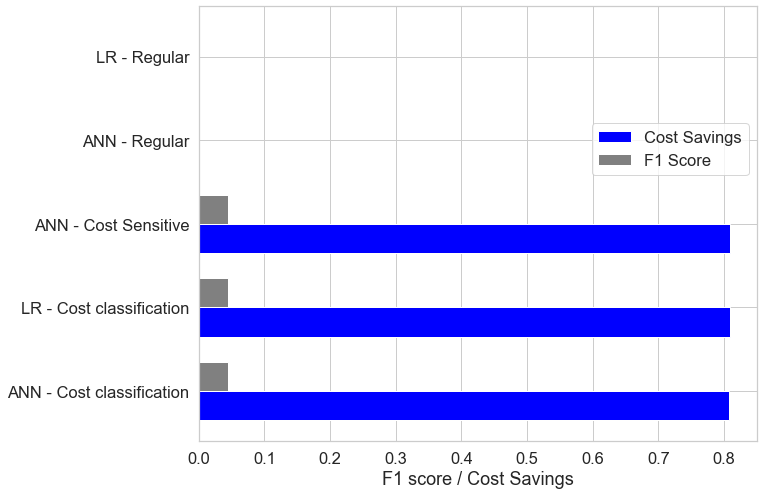

In [35]:
# All results: cost savings and F1-score
df_results.index = ['LR - Regular','ANN - Regular','ANN - Cost Sensitive', \
                    'LR - Cost classification','ANN - Cost classification']
df_results.columns = ['Cost Savings', 'F1 Score']

fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize': [8, 5], 'font.size': 22})
plt.rcParams.update({'font.size': 20, 'figure.figsize': [10,8]})
ax = df_results[::-1].plot.barh(ax=ax, color=['blue', 'gray'], width=0.7)
ax.legend(bbox_to_anchor=(1, 0.75))
ax.set_xlabel('F1 score / Cost Savings')
plt.show()

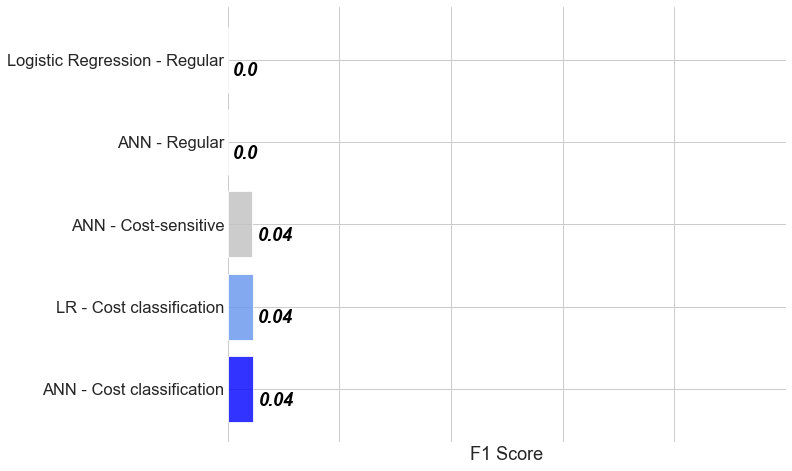

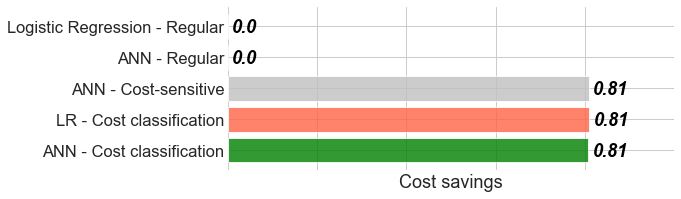

In [36]:
# LR regular + ANN regular + ANN cost sensitive + LR cost classification + ANN cost classification
fontsize = 18
df_5_f1 = df_results.iloc[:, 1]
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': fontsize, 'figure.figsize': [8, 3]})
ax.barh(['ANN - Cost classification', 'LR - Cost classification', 'ANN - Cost-sensitive',\
         'ANN - Regular', 'Logistic Regression - Regular'], df_5_f1[::-1], \
        color=['blue', 'cornflowerblue', 'silver', 'silver', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('F1 Score')
labels = list(df_5_f1[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value - 0.2, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()

df_5_cs = df_results.iloc[:, 0]
fig, ax = plt.subplots()
ax.barh(['ANN - Cost classification', 'LR - Cost classification', 'ANN - Cost-sensitive', \
         'ANN - Regular', 'Logistic Regression - Regular'], df_5_cs[::-1], \
        color=['green', 'tomato', 'silver', 'silver', 'silver'], alpha=0.8)
ax.set_xlim([0, 1])
ax.set_xlabel('Cost savings')
labels = list(df_5_cs[:].apply(lambda x: np.round(x, 2)))[::-1]
rects = ax.patches
for rect, label in zip(rects, labels):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    ax.text(x_value + 0.01, y_value - 0.2, label, color='black', fontsize=fontsize, style='italic', weight='bold')#,
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(top=False, bottom=False, right=False, axis='both', which='both', length=0)
plt.box(False)
plt.show()